### Pablo Chantada Saborido (pablo.chantada@udc.es)
### José Romero Conde (j.rconde@udc.es)

# CARGA DE DATOS

In [1]:
from Utils import DatasetProcess, reconstruction_plot, anomaly_report, plot_atipicos
from ConvModel import ConvModel
from AutoEncoder import TwoStepAutoEncoder, TwoStepClassifier, TwoStepTraining, OneStepAutoencoder, OneStepTraining
from OneClass import AnomalyDetector
from Contrastive import ContrastiveModel, SemiSupervisedContrastiveModel

In [2]:
unlabeled_train, x_train, y_train, x_val, y_val, x_test, y_test, one_hot_train, one_hot_val, one_hot_test = DatasetProcess.load_dataset()

In [3]:
#(x_train, y_train), (x_test, y_test) = DatasetProcess.load()


# Aplicar la función hold_out
#(x_train_no_labeled, x_train_labeled, y_train_labeled), (x_val, y_val), (x_test, y_test) = DatasetProcess.hold_out(
#    (x_train, y_train), (x_test, y_test), validation_size=1000
#)

#x_train_labeled = x_train_labeled.astype('float32') / 255.0
#x_val = x_val.astype('float32') / 255.0
#x_test = x_test.astype('float32') / 255.0

# Verificar las dimensiones
print(f"Datos no etiquetados: {unlabeled_train.shape}")
print(f"Datos etiquetados entrenamiento: {x_train.shape}")
print(f"Etiquetas entrenamiento: {y_train.shape}")
print(f"Datos validación: {x_val.shape}")
print(f"Etiquetas validación: {y_val.shape}")
print(f"Datos prueba: {x_test.shape}")
print(f"Etiquetas prueba: {y_test.shape}")

Datos no etiquetados: (33500, 32, 32, 3)
Datos etiquetados entrenamiento: (8250, 32, 32, 3)
Etiquetas entrenamiento: (8250, 1)
Datos validación: (8250, 32, 32, 3)
Etiquetas validación: (8250, 1)
Datos prueba: (10000, 32, 32, 3)
Etiquetas prueba: (10000, 1)


# EJERCICIO 1

Entrena un modelo, creado sobre TensorFlow, haciendo uso únicamente de las instancias etiquetadas de entrenamiento. Dicho modelo debe de tener al menos cuatro capas densas y/o convolucionales.

Responde a las siguientes preguntas:

1. ¿Qué red has escogido? ¿Por qué? ¿Cómo la has entrenado?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Qué conclusiones sacas de los resultados detallados en el punto anterior?

In [ ]:
model_base = ConvModel()
history_base = model_base.fit(
    x_train, 
    y_train,
    validation_data=(x_val, y_val),
    batch_size=128,
    epochs=1
)

In [ ]:
# Evalúa con el conjunto de prueba
test_accuracy = model_base.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba: {test_accuracy}")

model_base.plot(history_base)

# EJERCICIO 2

Entrena el mismo modelo, incorporando las instancias no etiquetadas de entrenamiento mediante la técnica de auto-aprendizaje. Opcionalmente, se ponderará cada instancia de entrada en función de su calidad (o certeza).

Responde a las siguientes preguntas:
1. ¿Qué parámetros has definido para el entrenamiento?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en el Ejercicio 1?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
# Función para crear modelos consistentes durante self-training
def create_model():
    return ConvModel(
        learning_rate=0.0005,  # Learning rate reducido para fine-tuning
        dropout_prob=0.25,     
        l2_lambda=0.005        
    )

# Aplica self-training con datos no etiquetados
final_model = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train,
    y_train=y_train,  
    unlabeled_data=unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.8,             
    train_epochs=1,
    verbose=1
)

# Evalúa el modelo final
final_accuracy = final_model.score(x_test, y_test)
print(f"Accuracy del modelo final con self-training: {final_accuracy}")
print(f"Mejora respecto al modelo base: {final_accuracy - test_accuracy:.4f}")

# EJERCICIO 3

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en dos pasos (primero el autoencoder, después el clasificador). La arquitectura del encoder debe ser exactamente la misma que la definida en los Ejercicios 1 y 2, a excepción del último bloque de capas.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los Ejercicios 1 y 2?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [ ]:
autoencoder = TwoStepAutoEncoder(
                                input_shape=unlabeled_train[0].shape,
                                learning_rate=0.006,
                                l2_lambda=0.0005,
                                dropout_prob=0.1)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)


In [ ]:
TwoStepTraining(autoencoder=autoencoder, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=405)

In [ ]:
reconstruction_plot(autoencoder, x_test)

In [ ]:
autoencoder.score(x_test)

# EJERCICIO 4

Entrena un modelo de aprendizaje semisupervisado de tipo autoencoder en un paso (autoencoder y clasificador al mismo tiempo). La arquitectura del autoencoder será la misma que la definida en el Ejercicio 3, y la combinación de encoder y clasificador será igual a la arquitectura definida en el
Ejercicio 1.

Responde a las siguientes preguntas:
1. ¿Cuál es la arquitectura del modelo? ¿Y sus hiperparámetros?
2. ¿Cuál es el rendimiento del modelo en entrenamiento? ¿Y en prueba?
3. ¿Se mejoran los resultados obtenidos en los ejercicios anteriores?
4. ¿Qué conclusiones sacas de los resultados detallados en los puntos anteriores?

In [3]:
one_step_autoencoder = OneStepAutoencoder(input_shape=unlabeled_train[0].shape,
                                learning_rate=0.0015,
                                decoder_extra_loss_weight = 0.45,
                                l2_lambda=0.00005,
                                dropout_prob=0.05)

2025-04-04 10:57:36.985038: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-04 10:57:36.985115: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-04 10:57:36.985130: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-04 10:57:36.985177: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-04 10:57:36.985209: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
h = OneStepTraining(one_step_autoencoder, 
                    x_train=x_train, 
                    y_train=one_hot_train, 
                    unlabeled_train=unlabeled_train,
                    batch_size=512,
                    epochs=1,
                    patience=10)

2025-04-04 10:57:41.745475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


82/82 ━━━━━━━━━━━━━━━━━━━━ 237s 3s/step - classifier_accuracy: 0.0238 - classifier_loss: 0.9097 - decoder_loss: 0.0601 - loss: 0.6990


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


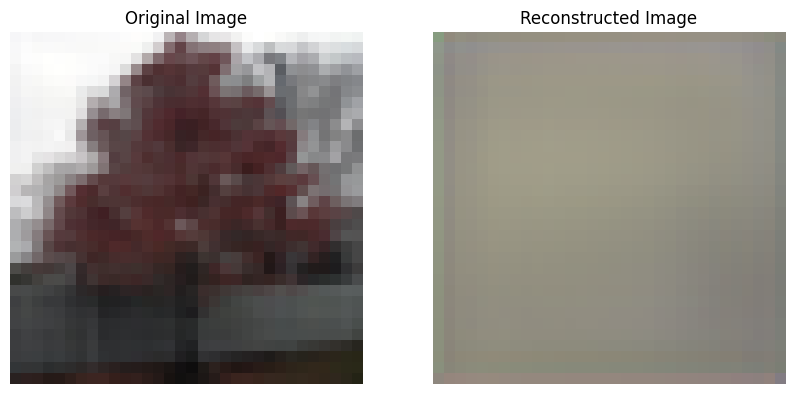

In [5]:
reconstruction_plot(one_step_autoencoder, x_test)

In [6]:
one_step_autoencoder.score(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


0.01

# EJERCICIO 5

Repite el mismo entrenamiento de los Ejercicios 1-4, pero eliminando las instancias no etiquetadas
más atípicas con respecto a los datos etiquetados. Se cumplirán los siguientes puntos:
- La arquitectura de la red de clasificación en una clase será la misma a la utilizada en el
clasificador del Ejercicio 1, a excepción de la capa de salida.
- Utiliza la técnica explicada en el Notebook 5, usando un valor de 𝑣 = 0,9.

Responde a la siguiente pregunta:
1. ¿Se mejoran los resultados con respecto a los anteriores ejercicios? ¿Qué conclusiones sacas de estos resultados?

In [4]:
anomalyDetector = AnomalyDetector(input_shape=(32,32,3), 
                        nu=.9,
                        l2_lambda=0.0,
                        learning_rate=0.0001,
                        dropout_prob=0.0)
anomalyDetector.fit(x_train, 
          batch_size=256, 
          epochs=2, 
          delta=.025, 
          steps=100)

/Users/pepe/carrera/3/2/ma2/ma2Python12/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-04-03 23:44:05.002775: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-03 23:44:05.003053: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-03 23:44:05.003085: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-03 23:44:05.003349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 23:44:05.003403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow de

Epoch 1/2


2025-04-03 23:44:06.559175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step- loss: 0.3736 
Cambiando r a 0.69512767 , max: 0.70241475 , min: 0.6930452
33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 656ms/step - loss: 0.3712
Epoch 2/2
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step- loss: 0.0720 
Cambiando r a 0.6791968 , max: 0.69847983 , min: 0.67324144
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 618ms/step - loss: 0.0717


<Sequential name=sequential, built=True>

In [ ]:
filtered_unlabeled_train, is_typical = anomaly_report(anomalyDetector, unlabeled_train)

In [ ]:
# creo que va pero no estoy seguro
#
# plot_atipicos(filtered_unlabeled_train, is_typical, unlabeled_train)

In [ ]:
# Ejercicio 2 con datos filtrados
model_self_filtered = ConvModel.self_training_v2(
    model_func=create_model,
    x_train=x_train_labeled,
    y_train=y_train_labeled,
    unlabeled_data=filtered_unlabeled_train,
    validation_data=(x_val, y_val),
    thresh=0.8,
    train_epochs=1
)

# Evaluar los modelos filtrados
test_accuracy_self_filtered = model_self_filtered.score(x_test, y_test)
print(f"Accuracy en conjunto de prueba (self-training filtrado): {test_accuracy_self_filtered}")

In [ ]:
# Ejercicio 3 con datos filtrados
autoencoder_filtered = TwoStepAutoEncoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.006,
    l2_lambda=0.0005,
    dropout_prob=0.1
)

classifier_filtered = TwoStepClassifier(
    l2_lambda=0.0005,
    dropout_prob=0.05,
    learning_rate=0.05
)

history_two_step_filtered = TwoStepTraining(
    autoencoder=autoencoder_filtered, 
    classifier=classifier_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train, 
    validation_data=(x_val, one_hot_val),
    batch_size_autoencoder=256,
    epochs_autoencoder=50,
    batch_size_classifier=256,
    epochs_classifier=100
)

# Evaluar modelos
test_accuracy_two_step_filtered = classifier_filtered.score(x_test, y_test)  # No se si es asi como se evaluaria este la verdad supongo que si
print(f"Accuracy del modelo one-step filtrado: {test_accuracy_two_step_filtered}")

In [ ]:
# Ejercicio 4 con datos filtrados
one_step_autoencoder_filtered = OneStepAutoencoder(
    input_shape=filtered_unlabeled_train[0].shape,
    learning_rate=0.0015,
    decoder_extra_loss_weight=0.45,
    l2_lambda=0.00005,
    dropout_prob=0.05
)

history_one_step_filtered = OneStepTraining(
    one_step_autoencoder_filtered, 
    x_train=x_train, 
    y_train=one_hot_train, 
    unlabeled_train=filtered_unlabeled_train,
    batch_size=256,
    epochs=100,
    patience=10
)
# Evaluar modelos
test_accuracy_one_step_filtered = one_step_autoencoder_filtered.score(x_test, y_test)
print(f"Accuracy del modelo one-step filtrado: {test_accuracy_one_step_filtered}")

# EJERCICIO 6

Repite los Ejercicios 3-5 cambiando el autencoder por la técnica definida en el apartado “Hay vida más allá del autoencoder” del Notebook 4. Contesta a las preguntas de dichos ejercicios. Se cumplirán los siguientes puntos:

1. La arquitectura de la red será igual a la parte encoder del autencoder definido en los
ejercicios anteriores.
2. El modelo debe entrenar correctamente.

In [5]:
# ejercicio 3 two step con todos los datos

cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)


In [6]:
TwoStepTraining(autoencoder=cModel, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=unlabeled_train, 
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=20,
                batch_size_classifier=4096,
                epochs_classifier=20, 
                contrastive=True)

...................................................................................................................................Epoch 1/20, Total Loss: 5.1303, Contrastive Loss: 4.9989, Clustering Loss: 0.1461
..................................................................................................................................Epoch 2/20, Total Loss: 4.5734, Contrastive Loss: 4.5734, Clustering Loss: 0.0000
..........................................

KeyboardInterrupt: 

In [ ]:
# ejercicio 4 ONE STEP con todos los datos

cSSLModel = SemiSupervisedContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.1, 
                          lambda_param=.9,
                          l2_lambda=0.0001,
                          dropout_prob=0.001,
                          lambda_supervised=1.0)


cSSLModel.train(
    X_unlabeled=unlabeled_train,  
    X_labeled=x_train,        
    y_labeled=y_train,       
    epochs=35,
    batch_size=128
)

cSSLModel.plot_training_history()

.............................................................................................................................................................................................................................................................................................................................................................
Epoch 1/35, Total Loss: 8.1865, Contrastive Loss: 4.1832, Clustering Loss: 0.0279, Supervised Loss: 3.9782
............................................................................................................................................................................................................................................................................................................................................................
Epoch 2/35, Total Loss: 7.8341, Contrastive Loss: 3.8475, Clustering Loss: 0.0000, Supervised Loss: 3.9866
.......................................................................................

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cSSLModel.plot_similarity_matrix(test_samples, n_samples=n_samples);

---

In [ ]:
# ejercicio 3 two step con los datos filtrados

cModel = ContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001)
classifier = TwoStepClassifier(
                              l2_lambda=0.0005,
                              dropout_prob=0.05,
                               learning_rate=0.05)

In [ ]:
TwoStepTraining(autoencoder=cModel, 
                classifier=classifier, 
                x_train=x_train, 
                y_train=one_hot_train, 
                unlabeled_train=filtered_unlabeled_train, # <-
                validation_data=(x_val, one_hot_val),
                batch_size_autoencoder=256,
                epochs_autoencoder=1,
                batch_size_classifier=4096,
                epochs_classifier=1, 
                contrastive=True)

In [ ]:
# ejercicio 4 ONE STEP con los datos filtrados

cSSLModel = SemiSupervisedContrastiveModel(unlabeled_train[0].shape, 
                          learning_rate=0.05, 
                          lambda_param=.9,
                          l2_lambda=0.001,
                          dropout_prob=0.001,
                          lambda_supervised=1.0)


cSSLModel.train(
    X_unlabeled=filtered_unlabeled_train,  # <-
    X_labeled=x_train,        
    y_labeled=y_train,       
    epochs=6,
    batch_size=128
)

cSSLModel.plot_training_history()

In [ ]:
n_samples = 100
test_samples = x_test[:n_samples].reshape(n_samples,32,32,3)

cSSLModel.plot_similarity_matrix(test_samples, n_samples=n_samples);